# Fraud Detection

In [1]:
## Imports:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, classification_report, confusion_matrix


## Dataset exploration

### [Dataset](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data) Description: Fraudulent Transactions Prediction

### Context  
The dataset supports the development of a model to predict fraudulent transactions for a financial company. Insights derived from the model are intended to inform an actionable plan. The data is in CSV format, containing **6,362,620 rows** and **10 columns**, simulating 30 days of transactions.

### Content  
The dataset includes the following features:

- **`step`**: Time unit in hours (1 step = 1 hour, total steps = 744).
- **`type`**: Type of transaction - `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`.
- **`amount`**: Transaction amount in local currency.
- **`nameOrig`**: Customer initiating the transaction.
- **`oldbalanceOrg`**: Initial balance of the sender before the transaction.
- **`newbalanceOrig`**: New balance of the sender after the transaction.
- **`nameDest`**: Recipient of the transaction.
- **`oldbalanceDest`**: Initial balance of the recipient before the transaction (missing for merchants, indicated by names starting with "M").
- **`newbalanceDest`**: New balance of the recipient after the transaction (missing for merchants).
- **`isFraud`**: Indicates if the transaction was fraudulent (simulated fraudulent behavior involves taking control of accounts to transfer and withdraw funds).
- **`isFlaggedFraud`**: Flags illegal attempts, defined as transferring amounts exceeding 200,000 in a single transaction.


In [2]:
data = pd.read_csv('raw_data/Fraud.csv')

print(f"Shape: {data.shape}")
data.head(3)

# Features and target
X = data.drop(columns=['isFraud', 'nameDest', 'nameOrig'])
y = data['isFraud']

Shape: (6362620, 11)


In [3]:
# Checking for null values
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Check for class imbalance
non_fraudulent = len(data[data['isFraud'] == 0])
fraudulent = len(data[data['isFraud'] == 1])

non_fraudulent_perc = np.round(non_fraudulent/data.shape[0], decimals=4)
fraudulent_perc = np.round(fraudulent/data.shape[0], decimals=4)

print(f"Non-fraudulent transactions: {non_fraudulent}\nFraudulent transactions: {fraudulent}")

print("-"*100)

print(f"Non-fraudulent transactions: {non_fraudulent_perc}\nFraudulent transactions: {fraudulent_perc}")

Non-fraudulent transactions: 6354407
Fraudulent transactions: 8213
----------------------------------------------------------------------------------------------------
Non-fraudulent transactions: 0.9987
Fraudulent transactions: 0.0013


In [6]:
data.duplicated().sum()

np.int64(0)

In [7]:
# Checking if all FlaggedFrauds are classified as 1 in isFrauds column
assert len(data[(data['isFlaggedFraud'] == 1) & (data['isFraud'] == 1)]) == len(data[data['isFlaggedFraud'] == 1])

In [8]:
def plot_isfraud_value_count(data : pd.DataFrame) -> None:
    """
    Plots a bar chart showing the counts of unique values in the 'isFraud' column of a DataFrame.

    This function creates a bar plot using Seaborn to visualize the distribution of values (0 and 1)
    in the 'isFraud' column of the given DataFrame. The chart includes:
    - Custom annotations above each bar displaying the exact count.
    - Customized y-axis tick labels for better readability.
    - A title and axis labels for clarity.

    Parameters:
    -----------
    data : pd.DataFrame
        A pandas DataFrame containing the 'isFraud' column with binary values (0 and 1).

    Returns:
    --------
    None
        This function displays the plot but does not return any value.

    Notes:
    ------
    - The function assumes the 'isFraud' column exists in the DataFrame and contains binary values.
    - The y-axis tick intervals are set to 1,000,000 by default and may require adjustment for datasets
      with smaller counts.
    """
    value_counts = data['isFraud'].value_counts()

    ax = sns.barplot(x=value_counts.index, y=value_counts.values, color='maroon')

    for index, value in enumerate(value_counts.values):
        ax.text(index, value + max(value_counts.values) * 0.02,
                str(value),
                ha='center', fontsize=12, fontweight='bold')

    ax.set_yticks(range(0, max(value_counts.values) + 1, 1000000))
    ax.set_yticklabels([f"{tick}" for tick in ax.get_yticks()])
    plt.xlabel('isFraud')
    plt.ylabel('Count')
    plt.title('Value count in isFraud Column')
    plt.ylim(0, max(value_counts.values) * 1.1)
    plt.show()

    return None

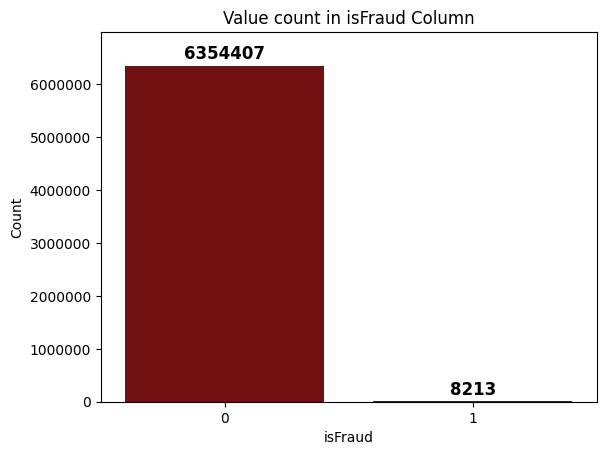

In [9]:
plot_isfraud_value_count(data)

In [10]:
# checking for correlations in numerical features:

def plot_correlation_map(data: pd.DataFrame) -> None:
    """
    Plots a heatmap of the correlation matrix for a given DataFrame.

    This function computes the correlation matrix of the numeric columns in the input DataFrame,
    then visualizes it using a heatmap with the upper triangle masked. The heatmap displays
    correlation coefficients as annotated values.

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing numeric data for which the correlation matrix is calculated.

    Returns:
    --------
    None
        This function does not return any value. It displays a heatmap plot of the correlation matrix.
    """
    corr = data.corr(numeric_only=True)
    trimask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(data=corr, annot=True, mask=trimask,square=True, linewidth=.1, fmt=".2f")

    plt.tight_layout()
    plt.show()

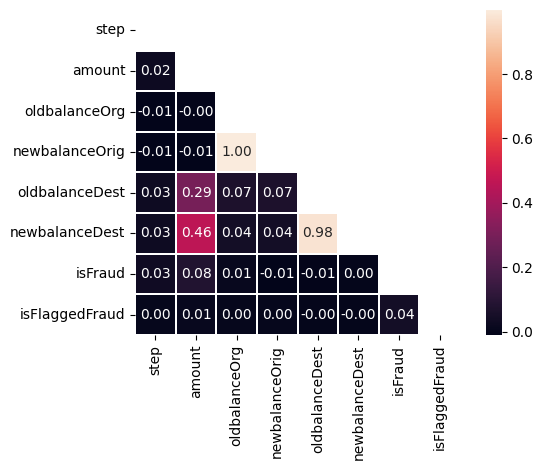

In [11]:
plot_correlation_map(data)

In [12]:
data.corr(numeric_only=True)['isFraud']

step              0.031578
amount            0.076688
oldbalanceOrg     0.010154
newbalanceOrig   -0.008148
oldbalanceDest   -0.005885
newbalanceDest    0.000535
isFraud           1.000000
isFlaggedFraud    0.044109
Name: isFraud, dtype: float64

The correlation index between some features indicates multicollinearity:

- **('oldbalanceDest', 'newbalanceDest')** = 0.9766  
- **('oldbalanceOrg', 'newbalanceOrig')** = 0.9988  

To address this issue, we should remove `newbalanceOrig` and `newbalanceDest` because they have a lower correlation with our target variable.


## Preprocessing

### UnderSampling

In [13]:
# Criar o balanceador
undersample = RandomUnderSampler(sampling_strategy='auto')

# Under-sampling
X_res, y_res = undersample.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

print(f"""
      X_train: {X_train.shape}
      X_test: {X_test.shape}
      y_train: {y_train.shape}
      y_test: {y_test.shape}
      """)


      X_train: (13140, 8)
      X_test: (3286, 8)
      y_train: (13140,)
      y_test: (3286,)
      


In [14]:
print(f"Samples for each class after UnderSampling:")
print(f"Class 0: {y_res.value_counts()[0]}")
print(f"Class 1: {y_res.value_counts()[1]}")

Samples for each class after UnderSampling:
Class 0: 8213
Class 1: 8213


In [15]:
numeric_columns = make_column_selector(dtype_include=['int64', 'float64'])
categorical_columns = make_column_selector(dtype_include=['object'])

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

full_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier())
])

In [16]:
full_pipe.fit(X_train, y_train)

y_pred = full_pipe.predict(X_test)

In [17]:
# Metrics in the test dataset
accuracy_under = accuracy_score(y_test, y_pred)
recall_under = recall_score(y_test, y_pred)
precision_under = precision_score(y_test, y_pred)
f1_under = f1_score(y_test, y_pred)
roc_auc_under = roc_auc_score(y_test, y_pred)

print(f"""
      Accuracy: {round(accuracy_under, 3)}
      Recall: {round(recall_under, 3)}
      Precision: {round(precision_under, 3)}
      F1 Score: {round(f1_under, 3)}
      ROC AUC: {round(roc_auc_under, 3)}
      """)


      Accuracy: 0.993
      Recall: 0.996
      Precision: 0.989
      F1 Score: 0.993
      ROC AUC: 0.993
      


In [18]:
cv = StratifiedKFold(n_splits=5)

cross_val = cross_validate(full_pipe, X_train, y_train, scoring = ['accuracy', 'recall', 'precision', 'average_precision', 'f1'], cv=cv)
cross_val

print(f"Accuracy : {cross_val['test_accuracy'].mean()}")
print(f"Recall : {cross_val['test_recall'].mean()}")
print(f"Precision : {cross_val['test_precision'].mean()}")
print(f"F1 : {cross_val['test_f1'].mean()}")
print(f"AVG_Precision : {cross_val['test_average_precision'].mean()}")

Accuracy : 0.9920852359208524
Recall : 0.9958684009181331
Precision : 0.9883066068350874
F1 : 0.9920724090861863
AVG_Precision : 0.9993714394859372


In [19]:
y_test_pred = full_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1608
           1       0.99      1.00      0.99      1678

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



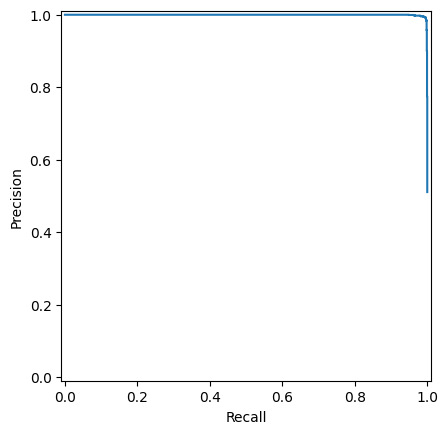

In [20]:
y_pred_prob = full_pipe.predict_proba(X_test)[:,1]


precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

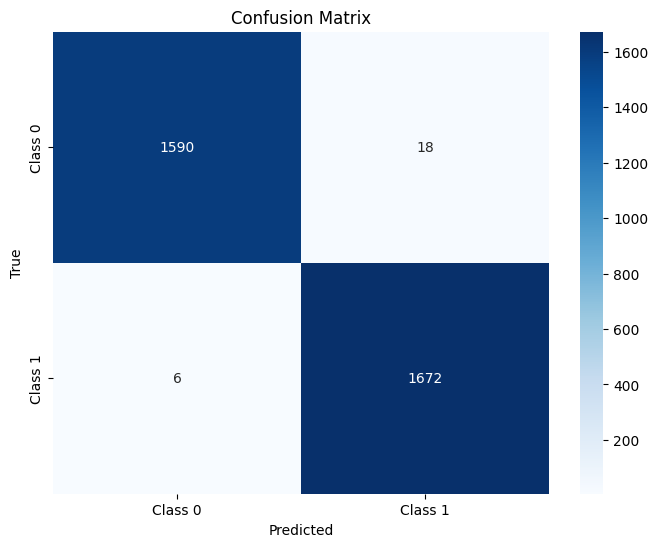

In [21]:
def plot_confusion_matrix(y_test : np.array, y_pred : np.array) -> None:
    """
    Plots a confusion matrix as a heatmap for binary classification results.

    Parameters:
    ----------
    y_test : np.array
        The ground truth (true labels) for the classification task.
    y_pred : np.array
        The predicted labels from the classification model.

    Returns:
    -------
    None
        The function displays a heatmap of the confusion matrix and does not return any value.

    Notes:
    -----
    - The confusion matrix is plotted with Seaborn's heatmap, showing counts for true positives,
      true negatives, false positives, and false negatives.
    - X-axis represents the predicted labels.
    - Y-axis represents the true labels.
    - Labels are assumed to represent binary classes ('Class 0' and 'Class 1').

    Example:
    -------
    >>> from sklearn.metrics import confusion_matrix
    >>> y_test = [0, 1, 0, 1]
    >>> y_pred = [0, 1, 1, 1]
    >>> plot_confusion_matrix(y_test, y_pred)
    """
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return None

plot_confusion_matrix(y_test, y_pred)

### UnderSampling + OverSampling

In [22]:
# Selecting columns by type
numeric_columns = make_column_selector(dtype_include=['int64', 'float64'])
categorical_columns = make_column_selector(dtype_include=['object'])

# Standard scaling for  the numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# OHE for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Creating model
model = XGBClassifier()

# Full pipe including SMOTE + UnderSampler
full_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5)),
    ('model', model)
])


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y)

Class distribution after SMOTE + RandomUnderSampler:

1. The SMOTE will generate synthetic instances for class 1. The number of instances in class 1 will be increased to 50% of the number of instances in class 0. In other words, class 1 will have approximately 6354407 * 0.5 = 3177203 instances.


2. The RandomUnderSampler will reduce the number of instances in class 0 to match the number of instances in class 1 after SMOTE. In other words, the number of instances in class 0 will be reduced to approximately 3177203.

3. 3177203 is the final number of samples for each class

In [24]:
full_pipe.fit(X_train, y_train)

y_pred = full_pipe.predict(X_test)

In [25]:
# Metrics in the test dataset
accuracy_5 = accuracy_score(y_test, y_pred)
recall_5 = recall_score(y_test, y_pred)
precision_5 = precision_score(y_test, y_pred)
f1_5 = f1_score(y_test, y_pred)
roc_auc_5 = roc_auc_score(y_test, y_pred)

print(f"""
      Accuracy: {round(accuracy_5, 2)}
      Recall: {round(recall_5, 2)}
      Precision: {round(precision_5, 2)}
      F1 Score: {round(f1_5, 2)}
      ROC AUC: {round(roc_auc_5, 2)}
      """)



      Accuracy: 1.0
      Recall: 0.99
      Precision: 0.39
      F1 Score: 0.56
      ROC AUC: 0.99
      


In [26]:
# Stratified cross validation
cv = StratifiedKFold(n_splits=5)

cross_val = cross_validate(full_pipe, X_train, y_train, scoring = ['accuracy', 'recall', 'precision', 'average_precision', 'f1'], cv=cv)

print(f"Accuracy : {cross_val['test_accuracy'].mean()}")
print(f"Recall : {cross_val['test_recall'].mean()}")
print(f"Precision : {cross_val['test_precision'].mean()}")
print(f"AVG_Precision : {cross_val['test_average_precision'].mean()}")
print(f"F1 : {cross_val['test_f1'].mean()}")

Accuracy : 0.9980266439762003
Recall : 0.9892142127369734
Precision : 0.3948216739011273
AVG_Precision : 0.9662359886267392
F1 : 0.564308523133696


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.39      0.99      0.56      2464

    accuracy                           1.00   1908786
   macro avg       0.70      0.99      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786



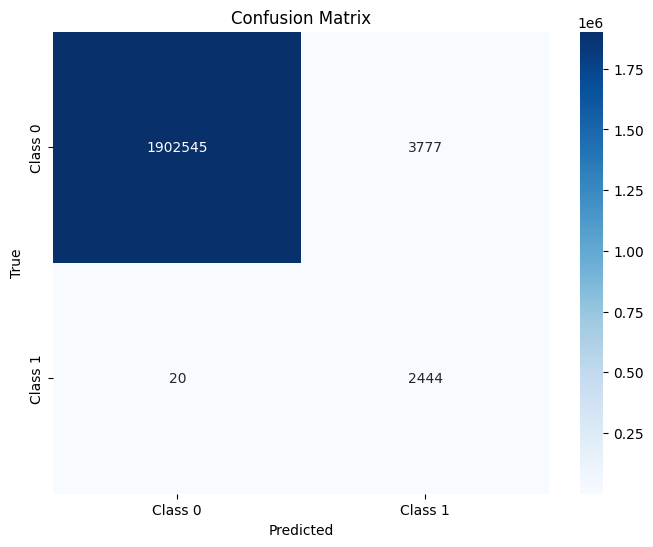

In [31]:
plot_confusion_matrix(y_test, y_pred)

### Threshold Adjustment

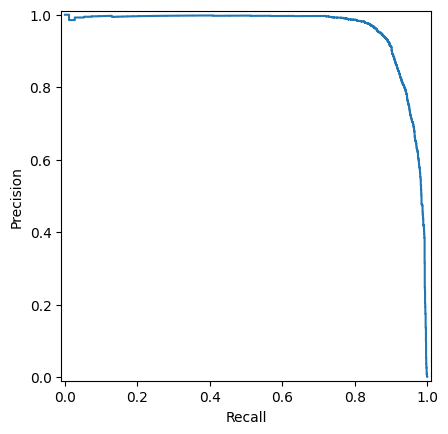

In [28]:
y_pred_prob = full_pipe.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [29]:
# Calculating pred_proba for 0.9 threshold
threshold = .99
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

In [30]:
# Scoring with threshold adjustment
accuracy_9 = accuracy_score(y_test, y_pred_adjusted)
recall_9 = recall_score(y_test, y_pred_adjusted)
precision_9 = precision_score(y_test, y_pred_adjusted)
f1_9 = f1_score(y_test, y_pred_adjusted)
roc_auc_9 = roc_auc_score(y_test, y_pred_adjusted)

print("Before threshold adjustment:")

print(f"""
      Accuracy: {round(accuracy_5, 2)}
      Recall: {round(recall_5, 2)}
      Precision: {round(precision_5, 2)}
      F1 Score: {round(f1_5, 2)}
      ROC AUC: {round(roc_auc_5, 2)}
      """)
print("-" *50)
print("After threshold adjustment")

print(f"""
      Accuracy: {round(accuracy_9, 2)}
      Recall: {round(recall_9, 2)}
      Precision: {round(precision_9, 2)}
      F1 Score: {round(f1_9, 2)}
      ROC AUC: {round(roc_auc_9, 2)}
      """)

Before threshold adjustment:

      Accuracy: 1.0
      Recall: 0.99
      Precision: 0.39
      F1 Score: 0.56
      ROC AUC: 0.99
      
--------------------------------------------------
After threshold adjustment

      Accuracy: 1.0
      Recall: 0.86
      Precision: 0.96
      F1 Score: 0.91
      ROC AUC: 0.93
      
